In [15]:
import numpy as np
import torch
import torch.nn as nn

class DCTLinearFactored(nn.Module):
    def __init__(self, input_size=28):
        super().__init__()
        self.input_size = input_size
        
        x = np.arange(input_size).reshape(-1, 1)
        u = np.arange(input_size).reshape(1, -1)
        cu = np.where(u == 0, np.sqrt(1/input_size), np.sqrt(2/input_size))
        cos_matrix = np.cos((2*x + 1) * u * np.pi / (2*input_size))
        self.register_buffer('basis_1d', torch.from_numpy((cu * cos_matrix).T).float())
        
        self.w_horizontal = nn.Parameter(torch.randn(input_size))
        self.w_vertical = nn.Parameter(torch.randn(input_size))
        self.bias = nn.Parameter(torch.zeros(1))
        
    def forward(self, x):
        batch_size = x.size(0)
        x_2d = x.view(batch_size, self.input_size, self.input_size)
        
        result = torch.zeros(batch_size, device=x.device)
        
        for i in range(self.input_size):
            for j in range(self.input_size):
                basis_2d = torch.outer(self.basis_1d[i], self.basis_1d[j])
                dct_coeff = (x_2d * basis_2d.unsqueeze(0)).sum(dim=[1, 2])
                weight = self.w_horizontal[i] * self.w_vertical[j]
                result += weight * dct_coeff
        
        return torch.sigmoid(result + self.bias).unsqueeze(1)

input_size = 28

standard = nn.Linear(input_size * input_size, 1)
dct_factored = DCTLinearFactored(input_size)

print(f"Standard Linear: {sum(p.numel() for p in standard.parameters())} params")
print(f"DCT Factored: {sum(p.numel() for p in dct_factored.parameters())} params")
print(f"Reduction: {sum(p.numel() for p in dct_factored.parameters()) / sum(p.numel() for p in standard.parameters()) * 100:.1f}%")

x = torch.randn(4, input_size * input_size)
out_standard = standard(x)
out_dct = dct_factored(x)

print(f"\nOutput shapes: {out_standard.shape}, {out_dct.shape}")
print(f"\nWeight matrix rank: 1 (factored as outer product)")

Standard Linear: 785 params
DCT Factored: 57 params
Reduction: 7.3%

Output shapes: torch.Size([4, 1]), torch.Size([4, 1])

Weight matrix rank: 1 (factored as outer product)


In [16]:
# Load and prepare the Breast Cancer Wisconsin dataset
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load dataset
data = load_breast_cancer()
X = data.data
y = data.target

print(f"\nDataset shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")

# Pad features to 36 (6x6) for 2D representation
import math
n_features = X.shape[1]
grid_size = int(math.ceil(math.sqrt(n_features)))
n_padded = grid_size ** 2

print(f"Padding from {n_features} to {n_padded} features ({grid_size}x{grid_size})")

X_padded = np.zeros((X.shape[0], n_padded))
X_padded[:, :n_features] = X

print(f"Target distribution: {np.bincount(y)}")
print("0: Malignant, 1: Benign")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

print(f"\nTraining set: {X_train_tensor.shape}")
print(f"Test set: {X_test_tensor.shape}")
print(f"Grid size for 2D DCT: {grid_size}x{grid_size}")

Using device: cuda

Dataset shape: (569, 30)
Number of features: 30
Padding from 30 to 36 features (6x6)
Target distribution: [212 357]
0: Malignant, 1: Benign

Training set: torch.Size([455, 36])
Test set: torch.Size([114, 36])
Grid size for 2D DCT: 6x6


In [17]:
# Use the original DCTLinearFactored for 2D input
# Create models
input_features = X_train_tensor.shape[1]
input_grid_size = int(math.sqrt(input_features))

standard_model = nn.Sequential(
    nn.Linear(input_features, 1),
    nn.Sigmoid()
).to(device)

# Use the 2D DCT model
dct_model = DCTLinearFactored(input_grid_size).to(device)

print(f"Input grid size: {input_grid_size}x{input_grid_size} = {input_features} features")
print(f"\nStandard Linear: {sum(p.numel() for p in standard_model.parameters())} params")
print(f"DCT Factored 2D: {sum(p.numel() for p in dct_model.parameters())} params")
print(f"Reduction: {sum(p.numel() for p in dct_model.parameters()) / sum(p.numel() for p in standard_model.parameters()) * 100:.1f}%")

Input grid size: 6x6 = 36 features

Standard Linear: 37 params
DCT Factored 2D: 13 params
Reduction: 35.1%


In [18]:
# Train the Standard Linear model
from torch.utils.data import TensorDataset, DataLoader

criterion = nn.BCELoss()
optimizer_standard = torch.optim.Adam(standard_model.parameters(), lr=0.01)

batch_size = 32
num_epochs = 1000

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("Training Standard Linear Model...")
for epoch in range(num_epochs):
    standard_model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        outputs = standard_model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        
        optimizer_standard.zero_grad()
        loss.backward()
        optimizer_standard.step()
        
        epoch_loss += loss.item()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}')

print("Standard model training completed!")

Training Standard Linear Model...
Epoch [100/1000], Loss: 0.0449
Epoch [100/1000], Loss: 0.0449
Epoch [200/1000], Loss: 0.0390
Epoch [200/1000], Loss: 0.0390
Epoch [300/1000], Loss: 0.0368
Epoch [300/1000], Loss: 0.0368
Epoch [400/1000], Loss: 0.0344
Epoch [400/1000], Loss: 0.0344
Epoch [500/1000], Loss: 0.0339
Epoch [500/1000], Loss: 0.0339
Epoch [600/1000], Loss: 0.0331
Epoch [600/1000], Loss: 0.0331
Epoch [700/1000], Loss: 0.0303
Epoch [700/1000], Loss: 0.0303
Epoch [800/1000], Loss: 0.0289
Epoch [800/1000], Loss: 0.0289
Epoch [900/1000], Loss: 0.0274
Epoch [900/1000], Loss: 0.0274
Epoch [1000/1000], Loss: 0.0269
Standard model training completed!
Epoch [1000/1000], Loss: 0.0269
Standard model training completed!


In [19]:
# Train the DCT Factored model
optimizer_dct = torch.optim.Adam(dct_model.parameters(), lr=0.01)

print("Training DCT Factored Model...")
for epoch in range(num_epochs):
    dct_model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        outputs = dct_model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        
        optimizer_dct.zero_grad()
        loss.backward()
        optimizer_dct.step()
        
        epoch_loss += loss.item()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}')

print("DCT model training completed!")

Training DCT Factored Model...
Epoch [100/1000], Loss: 0.0618
Epoch [100/1000], Loss: 0.0618
Epoch [200/1000], Loss: 0.0613
Epoch [200/1000], Loss: 0.0613
Epoch [300/1000], Loss: 0.0607
Epoch [300/1000], Loss: 0.0607
Epoch [400/1000], Loss: 0.0747
Epoch [400/1000], Loss: 0.0747
Epoch [500/1000], Loss: 0.0627
Epoch [500/1000], Loss: 0.0627
Epoch [600/1000], Loss: 0.0611
Epoch [600/1000], Loss: 0.0611
Epoch [700/1000], Loss: 0.0612
Epoch [700/1000], Loss: 0.0612
Epoch [800/1000], Loss: 0.0774
Epoch [800/1000], Loss: 0.0774
Epoch [900/1000], Loss: 0.0608
Epoch [900/1000], Loss: 0.0608
Epoch [1000/1000], Loss: 0.0610
DCT model training completed!
Epoch [1000/1000], Loss: 0.0610
DCT model training completed!


In [20]:
# Evaluate both models
standard_model.eval()
dct_model.eval()

with torch.no_grad():
    # Standard model predictions
    y_pred_standard_train = (standard_model(X_train_tensor).squeeze() > 0.5).float().cpu().numpy()
    y_pred_standard_test = (standard_model(X_test_tensor).squeeze() > 0.5).float().cpu().numpy()
    
    # DCT model predictions
    y_pred_dct_train = (dct_model(X_train_tensor).squeeze() > 0.5).float().cpu().numpy()
    y_pred_dct_test = (dct_model(X_test_tensor).squeeze() > 0.5).float().cpu().numpy()

# Calculate accuracies
print("=" * 50)
print("STANDARD LINEAR MODEL")
print("=" * 50)
print(f"Training Accuracy: {accuracy_score(y_train, y_pred_standard_train):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_standard_test):.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_standard_test, target_names=['Malignant', 'Benign']))

print("\n" + "=" * 50)
print("DCT FACTORED MODEL")
print("=" * 50)
print(f"Training Accuracy: {accuracy_score(y_train, y_pred_dct_train):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_dct_test):.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_dct_test, target_names=['Malignant', 'Benign']))

STANDARD LINEAR MODEL
Training Accuracy: 0.9912
Test Accuracy: 0.9737

Classification Report (Test Set):
              precision    recall  f1-score   support

   Malignant       0.98      0.95      0.96        42
      Benign       0.97      0.99      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


DCT FACTORED MODEL
Training Accuracy: 0.9824
Test Accuracy: 0.9211

Classification Report (Test Set):
              precision    recall  f1-score   support

   Malignant       0.85      0.95      0.90        42
      Benign       0.97      0.90      0.94        72

    accuracy                           0.92       114
   macro avg       0.91      0.93      0.92       114
weighted avg       0.93      0.92      0.92       114



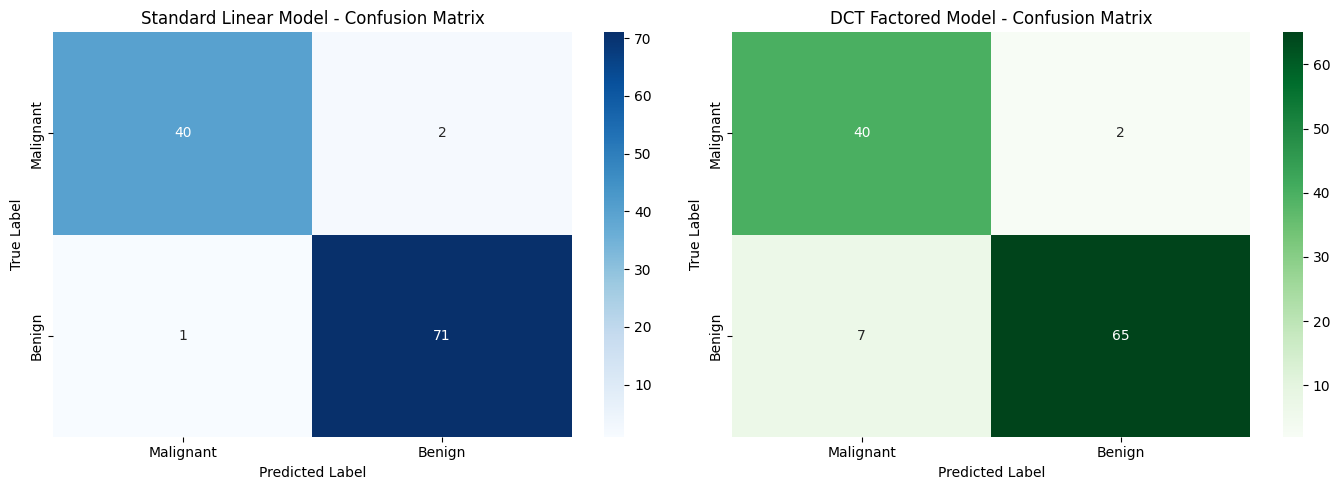

In [21]:
# Compare confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Standard model confusion matrix
cm_standard = confusion_matrix(y_test, y_pred_standard_test)
sns.heatmap(cm_standard, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
axes[0].set_title('Standard Linear Model - Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# DCT model confusion matrix
cm_dct = confusion_matrix(y_test, y_pred_dct_test)
sns.heatmap(cm_dct, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
axes[1].set_title('DCT Factored Model - Confusion Matrix')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

In [22]:
# Visualize DCT coefficient weights
dct_weights = dct_model.w_coeffs.detach().cpu().numpy()

plt.figure(figsize=(12, 4))
plt.bar(range(len(dct_weights)), dct_weights)
plt.xlabel('DCT Coefficient Index')
plt.ylabel('Weight Value')
plt.title('DCT Coefficient Weights (Frequency Domain Representation)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nModel Comparison Summary:")
print(f"Parameters - Standard: {sum(p.numel() for p in standard_model.parameters())}, "
      f"DCT: {sum(p.numel() for p in dct_model.parameters())}")
print(f"Parameter Reduction: {(1 - sum(p.numel() for p in dct_model.parameters()) / sum(p.numel() for p in standard_model.parameters())) * 100:.1f}%")

AttributeError: 'DCTLinearFactored' object has no attribute 'w_coeffs'